# Naive method, $e^+e^-\rightarrow\eta\pi^+\pi^-$ (1)
In this notebook we obtain the $e^+e^-\rightarrow\eta\pi^+\pi^-$ Born cross section using the naive method. Visible cross section data is generated using the model Born crosection. Here we consider only a relatively simple model $\rho(770),\,\rho(1450)\rightarrow\eta\rho(770)$. The statistical uncertainties of the generated visible cross section are proportional to the square roots of the cross section values. In this notebook, the following parameters are constant:
- $50$ equidistant c.m. energy points, 
- $\varepsilon(x,s)=1$.

In [1]:
import numpy as np
import json
import seaborn as sns
from PyISR import ISRSolverSLE
from ROOT import TFile, TCanvas
import matplotlib
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.sans-serif'] = ['Tahoma', 'DejaVu Sans',
                                          'Lucida Grande', 'Verdana']

Welcome to JupyROOT 6.24/02


Remove scrolling:

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
%matplotlib inline

Loading the model Born cross section

In [4]:
# Opening the file containing the model cross section
fl = TFile.Open('data/born_cs_etapipi_simple_model.root', 'read')
# Cloning the model cross section function
mBCsFcn = fl.Get('f_bcs').Clone()
# Vectorizing the model Born cross section function
mBCsVFcn = np.vectorize(lambda en: mBCsFcn.Eval(en))
# Closing the file
fl.Close()

Saving the current Matplotlib style:

In [5]:
# Current Matplotlib style parameters
mplStyleParams = dict(matplotlib.rcParams)
# Deprecated parameters
deprecatedParams = ['animation.avconv_args', 'animation.avconv_path', 
                    'animation.html_args', 'keymap.all_axes',
                   'savefig.jpeg_quality', 'text.latex.preview']
# Remove deprecated parameters in oder to avoid warnings
_ = list(map(lambda key : mplStyleParams.pop(key, None), deprecatedParams))

Function for reading visible cross section data:

In [6]:
def readVCS(path):
    fl = TFile.Open(path, "read")
    # Getting a pointer to the visible cross section in the form of TGraphErrors
    gvcs = fl.Get('vcs')
    # Number of c.m. energy points
    n = gvcs.GetN()
    # Reading c.m. energy array
    energy = np.frombuffer(gvcs.GetX(), dtype=np.float64, count=n)
    # Reading array of c.m. energy errors
    energyErr = np.frombuffer(gvcs.GetEX(), dtype=np.float64, count=n)
    # Reading visible cross section array
    vcs = np.frombuffer(gvcs.GetY(), dtype=np.float64, count=n)
    # Reading array of visible cross section errors
    vcsErr = np.frombuffer(gvcs.GetEY(), dtype=np.float64, count=n)
    fl.Close()
    return energy, vcs, energyErr, vcsErr

Function for obtaining numerical solution:

In [7]:
def solve(energy, vcs, energyErr, vcsErr, 
          enabled_energy_spread=False, 
          threshold_energy=0.827, 
          interp=None,
          efficiency=lambda x, en: 1.0):
    n = energy.shape[0]
    solver = ISRSolverSLE(n, energy, vcs, 
                          energyErr, vcsErr, 
                          threshold_energy, efficiency,
                          enabled_energy_spread)
    if type(interp) == str:
        with open(interp, 'r') as jfl:
            settings = json.load(jfl)
        
        print('Interpolation settings:')
        print(settings)
        solver.set_interp_settings(settings)
    elif type(interp) == list:
        print('Interpolation settings:')
        print(interp)
        solver.set_interp_settings(interp)
    
    solver.solve()
    return solver

Function for cross section plotting:

In [8]:
def csPlot(solver, title='Cross sections', fontsize=24):
    # Getting c.m. energy array
    ecm = solver.ecm()
    matplotlib.rcParams.update(mplStyleParams)
    f, (ax0, ax1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, sharex=True,
                                figsize=(9, 10))
    f.suptitle(title, fontsize=fontsize)
    ax1.tick_params(axis='both', which='major', labelsize=fontsize)
    ecm_dense = np.linspace(np.min(ecm), np.max(ecm), ecm.shape[0] * 20)
    interp = np.vectorize(lambda en: solver.interp_eval(en))(ecm_dense)
    ax0.errorbar(ecm, solver.vcs(), 
                xerr=solver.ecm_err(),
                yerr=solver.vcs_err(), fmt='o',
                markersize=5, capsize=3,
                label='Visible cross section', zorder=0)
    bcs_err = yerr=np.sqrt(np.diag(solver.bcs_cov_matrix()))
    ax0.errorbar(ecm, solver.bcs(), yerr=bcs_err, fmt='o',
                 markersize=5, capsize=3,
                label='Born cross section', zorder=1)
    ax0.plot(ecm_dense, interp, 'b--', label='Interpolation of the Born cross section', zorder=2)
    ax0.plot(ecm_dense, mBCsVFcn(ecm_dense), 'r-', label='Model Born cross section', zorder=3)
    mBCs_at_ecm =  mBCsVFcn(ecm)
    ax1.errorbar(ecm, solver.bcs() / mBCs_at_ecm, yerr=bcs_err / mBCs_at_ecm, fmt='o',
                 markersize=5, capsize=3,
                 label=r'Ratio $\frac{\sigma_{\rm B}}{\sigma^{\rm model}_{\rm B}}$',
            zorder=0)
    ax1.set_xlabel(r'$\sqrt{s}$ (GeV)', fontsize=fontsize)
    ax0.set_ylabel('cross section (nb)', fontsize=fontsize)
    ax0.legend(fontsize=fontsize, bbox_to_anchor=(1.05, 1))

Function for plotting matrices:

In [9]:
def matrixPlot(mx, title='', fontsize=24, fontscale=2.0):
    sns.set(font_scale=fontscale)
    f, ax = plt.subplots(figsize=(9, 7))
    f.suptitle(title, fontsize=fontsize)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    sns.heatmap(mx, ax=ax, square=True)

Function for plotting cross section ratio

In [10]:
def drawRatio(ratio_path):
    fontsize=24
    fl = TFile.Open(output_path, 'read')
    ratioGraph = fl.Get('means')
    cnt = ratioGraph.GetN()
    x = np.frombuffer(ratioGraph.GetX(), dtype=np.float64, count=cnt)
    y = np.frombuffer(ratioGraph.GetY(), dtype=np.float64, count=cnt)
    ey = np.frombuffer(ratioGraph.GetEY(), dtype=np.float64, count=cnt)
    fl.Close()
    matplotlib.rcParams.update(mplStyleParams)
    f, ax = plt.subplots(figsize=(9, 7))
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.errorbar(x, y + 1, 
                yerr=ey, fmt='o',
                markersize=5, capsize=3,
                label='Ratio', zorder=0)
    ax.set_xlabel(r'$\sqrt{s}$ (GeV)', fontsize=fontsize)
    ax.set_ylabel(r'$\sigma^{\rm numerical}_{\rm Born} / \sigma^{\rm model}_{\rm Born}$', fontsize=fontsize)

## No c.m. energy spread: $\sigma_E(s)=0\text{ MeV}$, piecewise linear interpolation
The piecewise linear interpolation of the unknown Born cross section is used by default

Condition number: 1.563490909895535


0

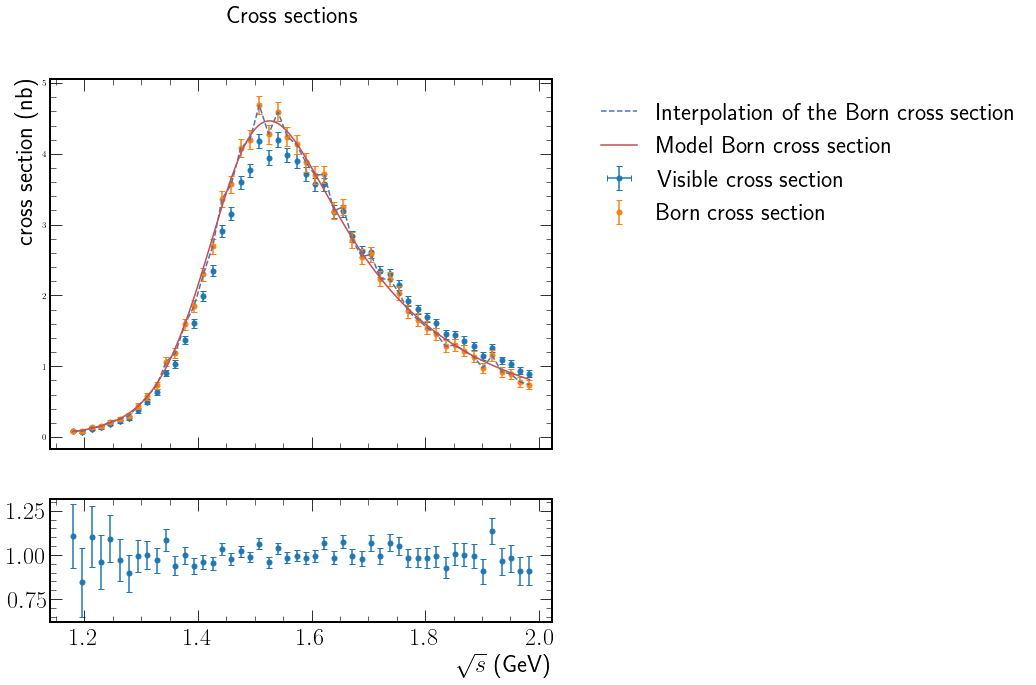

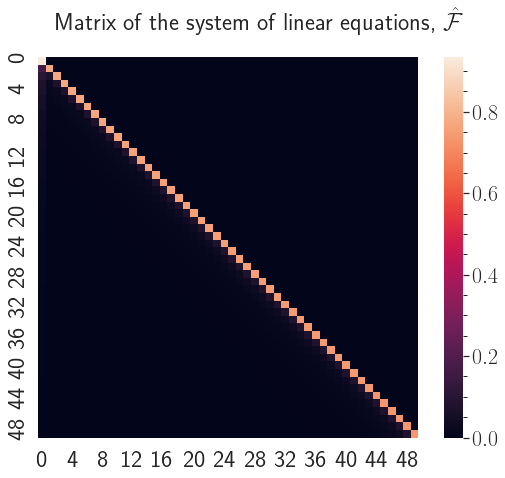

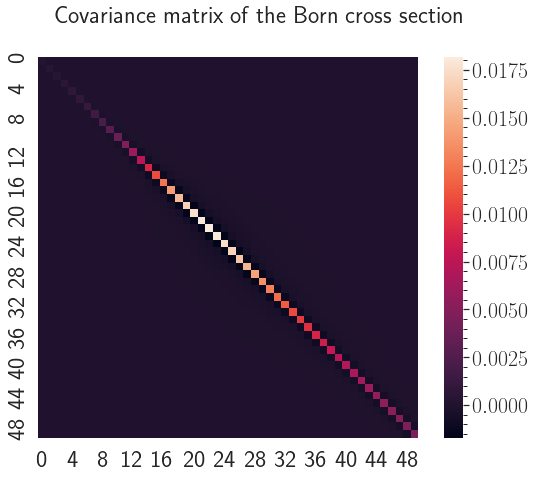

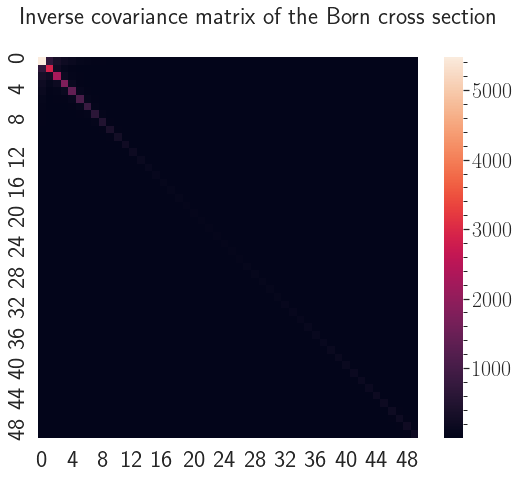

In [11]:
input_path = 'data/gen_visible_cs_etapipi_simple_model_no_energy_spread.root'
solver = solve(*readVCS(input_path))
print('Condition number: {}'.format(solver.condnum_eval()))
csPlot(solver)
matrixPlot(solver.intop_matrix(), title=r'Matrix of the system of linear equations, $\hat{\mathcal{F}}$')
matrixPlot(solver.bcs_cov_matrix(), title=r'Covariance matrix of the Born cross section')
matrixPlot(solver.bcs_inv_cov_matrix(), title=r'Inverse covariance matrix of the Born cross section')
solver.save('../shared/numerical_solution_naive_method_etapipi_simple_model_no_energy_spread.root')

### Ratio test

In [ ]:
input_path = 'data/gen_visible_cs_etapipi_simple_model_no_energy_spread.root'
output_path = '../shared/ratio_test_model_etapipi_simple_no_energy_spread_NaiveMethod.root'
solver = solve(*readVCS(input_path))
n = 100000
solver.ratio_test_model(n, input_path, 'vcsSRC', 'bcsSRC', output_path)
drawRatio(output_path)

## No c.m. energy spread: $\sigma_E=0\text{ MeV}$, custom interpolation
Interpolation settings: ```[[False, 0, 0], [True, 1, 49]]```. ```False``` means piecewise linear inerpolation, while ```True``` means cubic spline interpolation. The integer numbers are c.m. energy range indices. For example, indices ```0, 0``` are used to select just one c.m. energy range, which is located between the threshold energy and the first c.m. energy point. The first index is the Indices ```1, 49``` are used to select all the other $49$ c.m. energy ranges that are between the $50$ c.m. energy points.

In [ ]:
input_path = 'data/gen_visible_cs_etapipi_simple_model_no_energy_spread.root'
# Path to the .json file with interpolation settings
interp_settings_path='data/interp_settings_etapipi_1.json'
solver = solve(*readVCS(input_path), interp=interp_settings_path)
print('Condition number: {}'.format(solver.condnum_eval()))
csPlot(solver)
matrixPlot(solver.intop_matrix(), title=r'Matrix of the system of linear equations, $\hat{\mathcal{F}}$')
matrixPlot(solver.bcs_cov_matrix(), title=r'Covariance matrix of the Born cross section')

## No c.m. energy spread: $\sigma_E=0\text{ MeV}$,  another custom interpolation

In [ ]:
input_path = 'data/gen_visible_cs_etapipi_simple_model_no_energy_spread.root'
# Interpolation settings
interp_settings=[[False, 0, 0], [True, 1, 10,], [False, 11, 20], [True, 21, 49]]
solver = solve(*readVCS(input_path), interp=interp_settings)
print('Condition number: {}'.format(solver.condnum_eval()))
csPlot(solver)
matrixPlot(solver.intop_matrix(), title=r'Matrix of the system of linear equations, $\hat{\mathcal{F}}$')
matrixPlot(solver.bcs_cov_matrix(), title=r'Covariance matrix of the Born cross section')

## $\sigma_E=0\text{ MeV}$, $\chi^2$ test
Fit parameters:
p0 - amplitude
p1 - NDF

In [ ]:
input_path = 'data/gen_visible_cs_etapipi_simple_model_no_energy_spread.root'
output_path = '../shared/chi2_test_model_etapipi_simple_model_no_energy_spread.root'
solver = solve(*readVCS(input_path))
n = 100000
initial_ampl = 1.e+4
solver.chi2_test_model(n, initial_ampl, input_path, 'vcsSRC', 'bcsSRC', output_path)
cnv = TCanvas()
fl = TFile.Open(output_path, 'read')
chi2Hist = fl.Get('chi2Hist').Clone()
chi2Hist.SetDirectory(0)
fl.Close()
chi2Hist.Draw()
cnv.Draw()

## $\sigma_E(s)=2\text{ MeV}$, piecewise linear interpolation

In [ ]:
input_path = 'data/gen_visible_cs_etapipi_simple_model_energy_spread_2MeV.root'
solver = solve(*readVCS(input_path), enabled_energy_spread=True)
print('Condition number: {}'.format(solver.condnum_eval()))
csPlot(solver)
matrixPlot(solver.intop_matrix(), title=r'Matrix of the system of linear equations, $\hat{\mathcal{G}}\hat{\mathcal{F}}$')
matrixPlot(solver.bcs_cov_matrix(), title=r'Covariance matrix of the Born cross section')

## $\sigma_E=2\text{ MeV}$, $\chi^2$ test
Fit parameters:
p0 - amplitude
p1 - NDF

In [ ]:
input_path = 'data/gen_visible_cs_etapipi_simple_model_energy_spread_2MeV.root'
output_path = '../shared/chi2_test_model_etapipi_simple_model_energy_spread_2MeV_NaiveMethod.root'
solver = solve(*readVCS(input_path), enabled_energy_spread=True)
n = 100000
initial_ampl = 1.e+4
solver.chi2_test_model(n, initial_ampl, input_path, 'vcsSRC', 'bcsSRC', output_path)
cnv = TCanvas()
fl = TFile.Open(output_path, 'read')
chi2Hist = fl.Get('chi2Hist').Clone()
chi2Hist.SetDirectory(0)
fl.Close()
chi2Hist.Draw()
cnv.Draw()

## $\sigma_E(s)=5\text{ MeV}$, piecewise linear interpolation

In [ ]:
input_path = 'data/gen_visible_cs_etapipi_simple_model_energy_spread_5MeV.root'
solver = solve(*readVCS(input_path), enabled_energy_spread=True)
print('Condition number: {}'.format(solver.condnum_eval()))
csPlot(solver)
matrixPlot(solver.intop_matrix(), title=r'Matrix of the system of linear equations, $\hat{\mathcal{G}}\hat{\mathcal{F}}$')
matrixPlot(solver.bcs_cov_matrix(), title=r'Covariance matrix of the Born cross section')

## $\sigma_E=5\text{ MeV}$, $\chi^2$ test
Fit parameters:
p0 - amplitude
p1 - NDF

In [ ]:
input_path = 'data/gen_visible_cs_etapipi_simple_model_energy_spread_5MeV.root'
output_path = '../shared/chi2_test_model_etapipi_simple_model_energy_spread_5MeV_NaiveMethod.root'
solver = solve(*readVCS(input_path), enabled_energy_spread=True)
n = 100000
initial_ampl = 1.e+4
solver.chi2_test_model(n, initial_ampl, input_path, 'vcsSRC', 'bcsSRC', output_path)
cnv = TCanvas()
fl = TFile.Open(output_path, 'read')
chi2Hist = fl.Get('chi2Hist').Clone()
chi2Hist.SetDirectory(0)
fl.Close()
chi2Hist.Draw()
cnv.Draw()

## $\sigma_E(s) = 10\text{ MeV}$, piecewise linear interpolation

In [ ]:
input_path = 'data/gen_visible_cs_etapipi_simple_model_energy_spread_10MeV.root'
solver = solve(*readVCS(input_path), enabled_energy_spread=True)
print('Condition number: {}'.format(solver.condnum_eval()))
csPlot(solver)
matrixPlot(solver.intop_matrix(), title=r'Matrix of the system of linear equations, $\hat{\mathcal{G}}\hat{\mathcal{F}}$')
matrixPlot(solver.bcs_cov_matrix(), title=r'Covariance matrix of the Born cross section')

## $\sigma_E=10\text{ MeV}$, $\chi^2$ test
Fit parameters:
p0 - amplitude
p1 - NDF

In [ ]:
input_path = 'data/gen_visible_cs_etapipi_simple_model_energy_spread_10MeV.root'
output_path = '../shared/chi2_test_model_etapipi_simple_model_energy_spread_10MeV.root'
solver = solve(*readVCS(input_path), enabled_energy_spread=True)
n = 100000
initial_ampl = 1.e+4
solver.chi2_test_model(n, initial_ampl, input_path, 'vcsSRC', 'bcsSRC', output_path)
cnv = TCanvas()
fl = TFile.Open(output_path, 'read')
chi2Hist = fl.Get('chi2Hist').Clone()
chi2Hist.SetDirectory(0)
fl.Close()
chi2Hist.Draw()
cnv.Draw()

## $\sigma_E=10\text{ MeV}$, $\chi^2$ test, custom interpolation
Fit parameters:
p0 - amplitude
p1 - NDF

In [ ]:
input_path = 'data/gen_visible_cs_etapipi_simple_model_energy_spread_10MeV.root'
output_path = '../shared/chi2_test_model_etapipi_simple_model_energy_spread_10MeV_custom_interp_NaiveMathod.root'
interp_settings=[[False, 0, 0], [True, 1, 49]]
solver = solve(*readVCS(input_path), enabled_energy_spread=True, interp=interp_settings)
n = 100000
initial_ampl = 1.e+4
solver.chi2_test_model(n, initial_ampl, input_path, 'vcsSRC', 'bcsSRC', output_path)
cnv = TCanvas()
fl = TFile.Open(output_path, 'read')
chi2Hist = fl.Get('chi2Hist').Clone()
chi2Hist.SetDirectory(0)
fl.Close()
chi2Hist.Draw()
cnv.Draw()

## $\sigma_E(s) = 20\text{ MeV}$, piecewise linear interpolation

In [ ]:
input_path = 'data/gen_visible_cs_etapipi_simple_model_energy_spread_20MeV.root'
solver = solve(*readVCS(input_path), enabled_energy_spread=True)
print('Condition number: {}'.format(solver.condnum_eval()))
csPlot(solver)
matrixPlot(solver.intop_matrix(), title=r'Matrix of the system of linear equations, $\hat{\mathcal{G}}\hat{\mathcal{F}}$')
matrixPlot(solver.bcs_cov_matrix(), title='Covariance matrix of the Born cross section')

## $\sigma_E=10\text{ MeV}$, $\chi^2$ test
Fit parameters:
p0 - amplitude
p1 - NDF

In [ ]:
input_path = 'data/gen_visible_cs_etapipi_simple_model_energy_spread_20MeV.root'
output_path = '../shared/chi2_test_model_etapipi_simple_model_energy_spread_20MeV_NaiveMethod.root'
solver = solve(*readVCS(input_path), enabled_energy_spread=True)
n = 100000
initial_ampl = 1.e+4
solver.chi2_test_model(n, initial_ampl, input_path, 'vcsSRC', 'bcsSRC', output_path)
cnv = TCanvas()
fl = TFile.Open(output_path, 'read')
chi2Hist = fl.Get('chi2Hist').Clone()
chi2Hist.SetDirectory(0)
fl.Close()
chi2Hist.Draw()
cnv.Draw()

## $\sigma_E(s)=50\text{ MeV}$, piecewise linear interpolation

In [ ]:
input_path = 'data/gen_visible_cs_etapipi_simple_model_energy_spread_50MeV.root'
solver = solve(*readVCS(input_path), enabled_energy_spread=True)
print('Condition number: {}'.format(solver.condnum_eval()))
csPlot(solver)
matrixPlot(solver.intop_matrix(), title=r'Matrix of the system of linear equations, $\hat{\mathcal{G}}\hat{\mathcal{F}}$')
matrixPlot(solver.bcs_cov_matrix(), title='Covariance matrix of the Born cross section')

## $\sigma_E=50\text{ MeV}$, $\chi^2$ test
Fit parameters:
p0 - amplitude
p1 - NDF

In [ ]:
input_path = 'data/gen_visible_cs_etapipi_simple_model_energy_spread_50MeV.root'
output_path = '../shared/chi2_test_model_etapipi_simple_model_energy_spread_50MeV_NaiveMethod.root'
solver = solve(*readVCS(input_path), enabled_energy_spread=True)
n = 100000
initial_ampl = 1.e+4
solver.chi2_test_model(n, initial_ampl, input_path, 'vcsSRC', 'bcsSRC', output_path)
cnv = TCanvas()
fl = TFile.Open(output_path, 'read')
chi2Hist = fl.Get('chi2Hist').Clone()
chi2Hist.SetDirectory(0)
fl.Close()
chi2Hist.Draw()
cnv.Draw()